https://data.galaxyzoo.org/

https://data.galaxyzoo.org/gz_trees/gz_trees.html Guide

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s
from scipy.special import logit, expit
from preprocess import GalaxyZooPreprocessor
from sklearn.linear_model import LinearRegression
from data_load import load
from functools import reduce
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gaussian_kde

# Load and Preprocess Data

In [2]:
np.random.seed(42)

In [3]:
# pip install pymc
# pip install seaborn
# pip install astropy
#pip install pygam

In [4]:
df = load()
df.shape
print(df.shape)
print(df.columns.tolist())

(243500, 64)
['target', 'OBJID', 'RUN', 'RERUN', 'CAMCOL', 'FIELD', 'OBJ', 'RA', 'DEC', 'PETROR50_R', 'PETROR90_R', 'PETROMAG_U', 'PETROMAG_G', 'PETROMAG_R', 'PETROMAG_I', 'PETROMAG_Z', 'PETROMAGERR_U', 'PETROMAGERR_G', 'PETROMAGERR_R', 'PETROMAGERR_I', 'PETROMAGERR_Z', 'PSFMAG_R', 'FIBERMAG_R', 'DEVMAG_R', 'DEVMAGERR_R', 'EXPMAG_R', 'EXPMAGERR_R', 'FRACDEV_R', 'MU50_R', 'EXTINCTION_U', 'EXTINCTION_G', 'EXTINCTION_R', 'EXTINCTION_I', 'EXTINCTION_Z', 'ROWC_U', 'COLC_U', 'ROWC_G', 'COLC_G', 'ROWC_R', 'COLC_R', 'ROWC_I', 'COLC_I', 'ROWC_Z', 'COLC_Z', 'CMODELMAG_R', 'CMODELMAGERR_R', 'REDSHIFT', 'REDSHIFTERR', 'PETROMAG_MU', 'PETROMAG_MG', 'PETROMAG_MR', 'PETROMAG_MI', 'PETROMAG_MZ', 'PETROMAGERR_MU', 'PETROMAGERR_MG', 'PETROMAGERR_MR', 'PETROMAGERR_MI', 'PETROMAGERR_MZ', 'PETROR50_R_KPC', 'REGION', 'PETROR50_R_KPC_SIMPLE_BIN', 'PETROMAG_MR_SIMPLE_BIN', 'REDSHIFT_SIMPLE_BIN', 'WVT_BIN']


In [5]:
preprocessor = GalaxyZooPreprocessor()
df = preprocessor.preprocess(df)
df.shape

(229168, 37)

# EDA

## Correction for Extinction

https://www.sdss4.org/dr17/algorithms/magnitudes/#ExtinctionCorrection

## Histograms

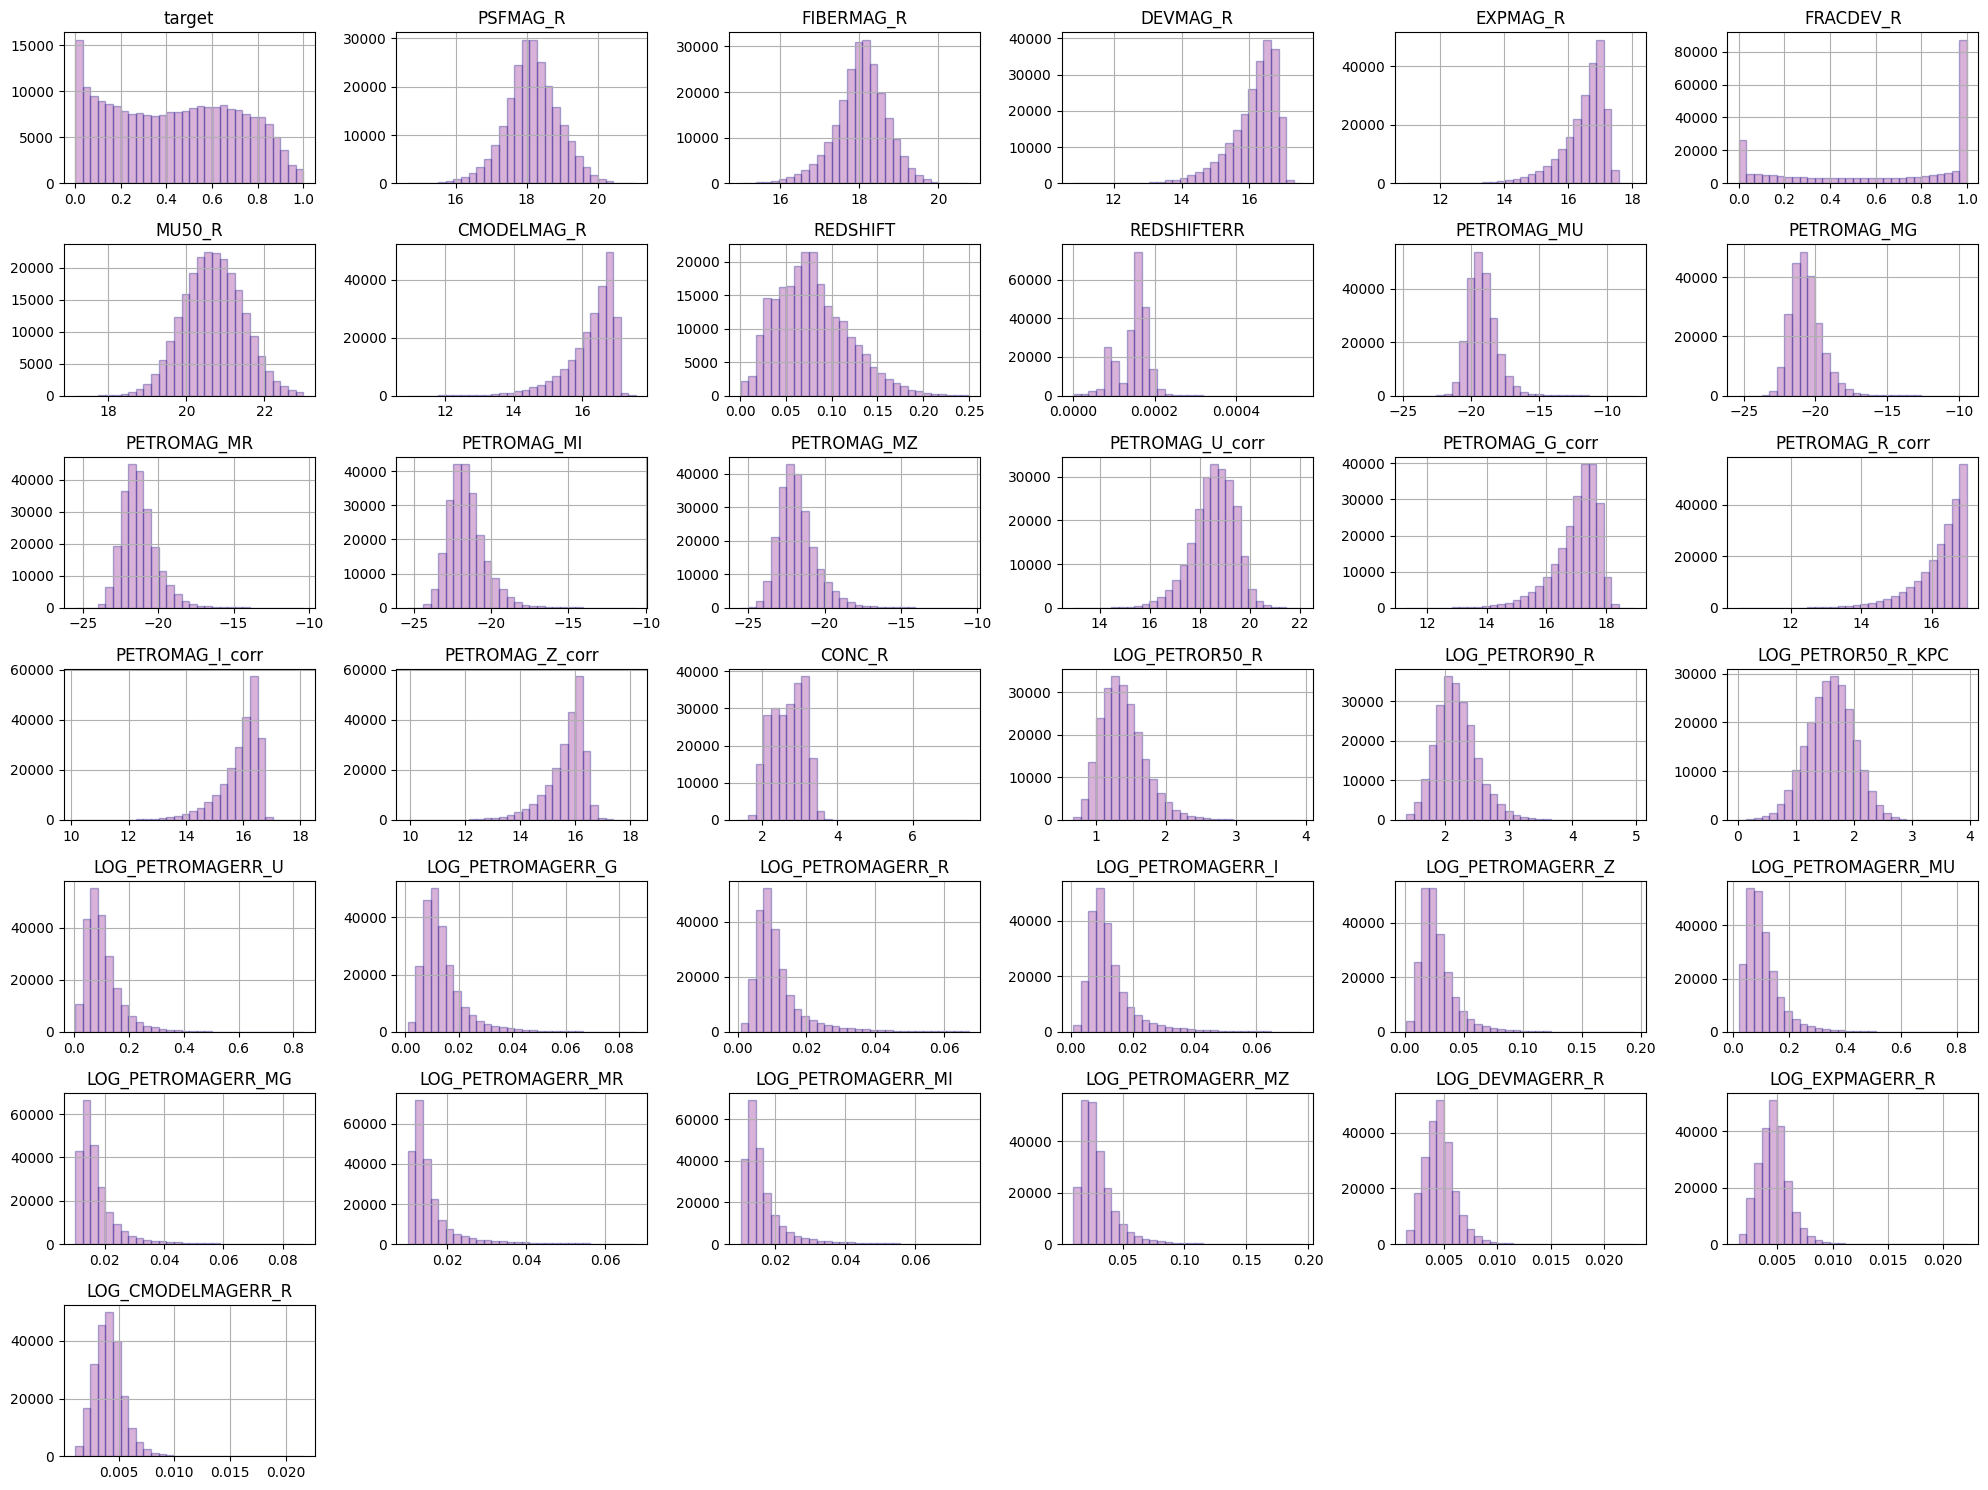

In [6]:
numeric_cols = df.select_dtypes(include='number').columns

# Plot histograms for each numeric column
df[numeric_cols].hist(bins=30, figsize=(20, 15), color='purple', edgecolor='navy', alpha = 0.3)
plt.tight_layout()
plt.show()

## Correlation

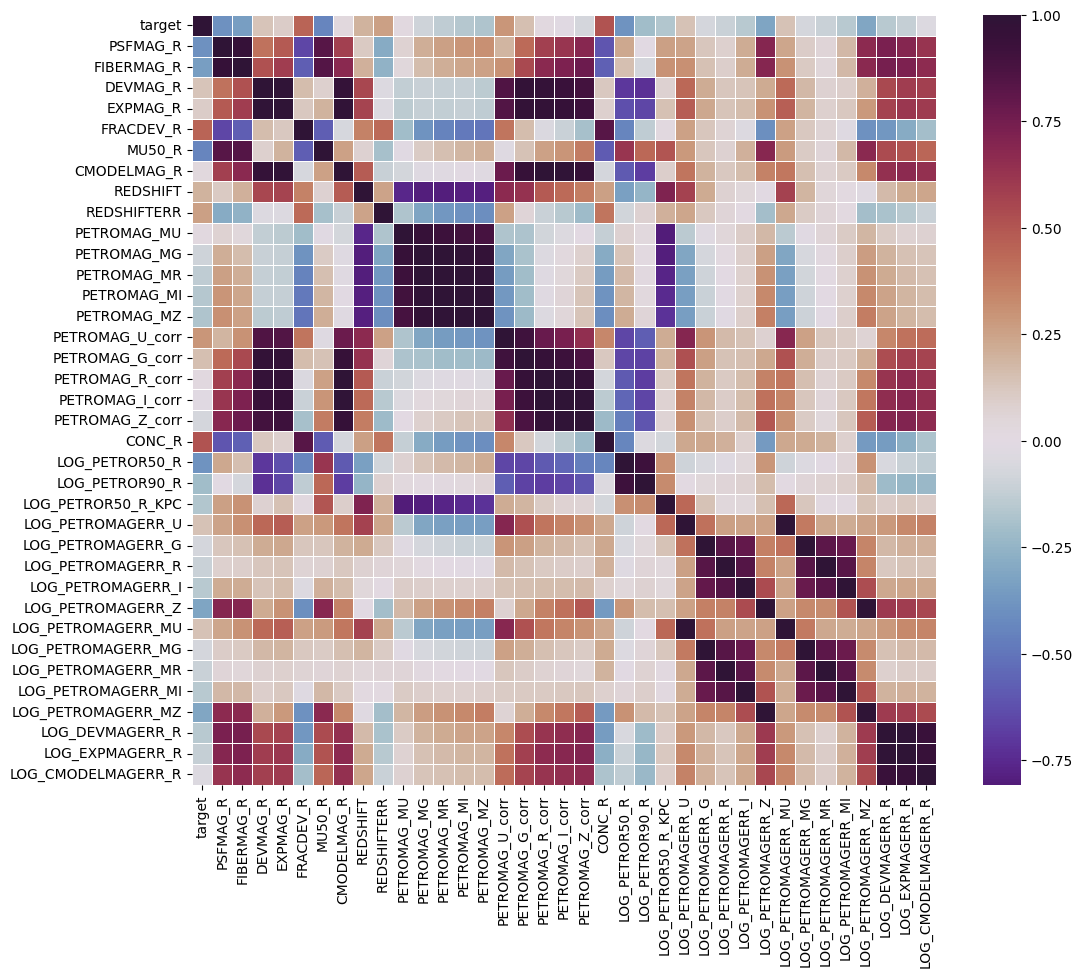

In [7]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), cmap='twilight_shifted', center=0, annot=False, linewidths=0.5)
# plt.title('Correlation Heatmap')
plt.show()

In [8]:
numeric_cols = df.select_dtypes(include='number').columns

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr().abs()

# Unstack and reset index to get pairs
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Absolute Correlation']

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs['Feature 1'] != corr_pairs['Feature 2']]

# Drop duplicate pairs (A-B and B-A)
corr_pairs['Sorted Pair'] = corr_pairs.apply(lambda row: tuple(sorted([row['Feature 1'], row['Feature 2']])), axis=1)
corr_pairs = corr_pairs.drop_duplicates(subset='Sorted Pair').drop(columns='Sorted Pair')

# Sort by absolute correlation
top_corr = corr_pairs.sort_values(by='Absolute Correlation', ascending=False)

# Display top results
print(top_corr.head(30))

              Feature 1           Feature 2  Absolute Correlation
917   LOG_PETROMAGERR_U  LOG_PETROMAGERR_MU              0.999872
1069  LOG_PETROMAGERR_Z  LOG_PETROMAGERR_MZ              0.999250
457         PETROMAG_MR         PETROMAG_MI              0.997660
495         PETROMAG_MI         PETROMAG_MZ              0.997159
955   LOG_PETROMAGERR_G  LOG_PETROMAGERR_MG              0.995746
1031  LOG_PETROMAGERR_I  LOG_PETROMAGERR_MI              0.995240
993   LOG_PETROMAGERR_R  LOG_PETROMAGERR_MR              0.994863
276         CMODELMAG_R     PETROMAG_R_corr              0.994224
419         PETROMAG_MG         PETROMAG_MR              0.994104
647     PETROMAG_R_corr     PETROMAG_I_corr              0.993572
458         PETROMAG_MR         PETROMAG_MZ              0.992485
1293    LOG_DEVMAGERR_R     LOG_EXPMAGERR_R              0.992352
277         CMODELMAG_R     PETROMAG_I_corr              0.988578
115            DEVMAG_R            EXPMAG_R              0.986480
685     PE

Features selected for scatter plots: ['target', 'CONC_R', 'FRACDEV_R', 'PETROMAG_U_corr', 'REDSHIFTERR', 'REDSHIFT', 'LOG_PETROMAGERR_MZ', 'LOG_PETROMAGERR_Z', 'FIBERMAG_R', 'LOG_PETROR50_R', 'PSFMAG_R', 'MU50_R']


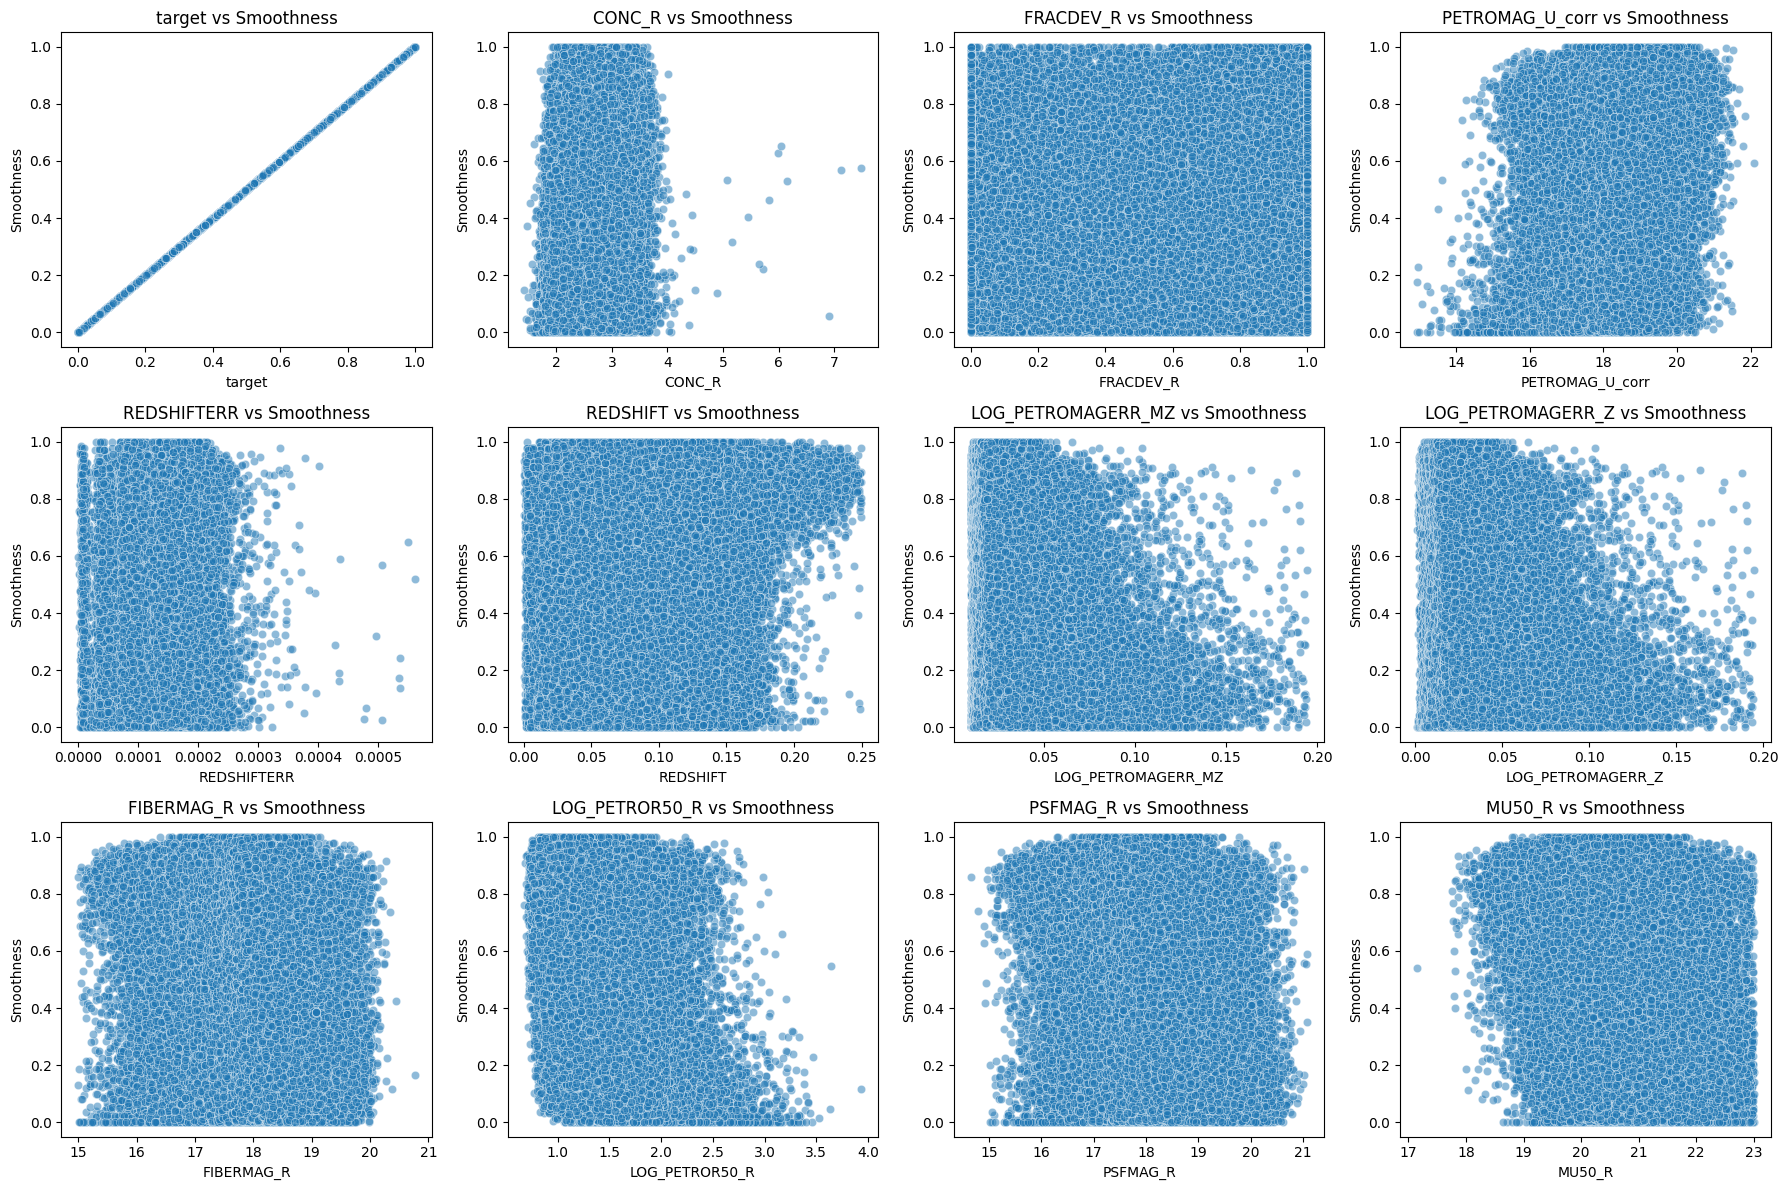

In [14]:
# Compute correlations with target
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 't01_smooth_or_features_a01_smooth_debiased']

# Get correlation series with target only
target_corr = df[numeric_cols].corrwith(df['target']).dropna()

# Sort correlations
target_corr_sorted = target_corr.sort_values(ascending=False)

# Select top 6 positive and top 6 negative features
top_features = list(target_corr_sorted.head(6).index) + list(target_corr_sorted.tail(6).index)
print("Features selected for scatter plots:", top_features)

# Plot scatter plots
plt.figure(figsize=(18, 12))
for i, feature in enumerate(top_features):
    plt.subplot(3, 4, i+1)
    sns.scatterplot(data=df, x=feature, y='target', alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Smoothness')
    plt.title(f'{feature} vs Smoothness')

plt.tight_layout()
plt.show()

# SPLIT

In [15]:
# Split df into selection and inference sets (50/50)
df_selection, df_inference = train_test_split(df, test_size=0.6)

print("Selection set size:", df_selection.shape)
print("Inference set size:", df_inference.shape)

Selection set size: (91667, 37)
Inference set size: (137501, 37)


# GAM

In [16]:
# 3. Build GAM model
# -------------------------
def build_gam(n_features, spline_k = 8, lamb = 1, max_iter = 1000):
    terms = s(0, n_splines=spline_k)
    for i in range(1, n_features):
        terms += s(i, n_splines=spline_k)

    return LinearGAM(terms, lam = lamb, max_iter=max_iter)

In [17]:
def gam_inference(gam_fit, X_train, X_test, y_train, y_test):
    y_train_hat_logit = gam_fit.predict(X_train)
    y_test_hat_logit = gam_fit.predict(X_test)
    y_train_hat = expit(y_train_hat_logit)
    y_test_hat = expit(y_test_hat_logit)
    y_train_prob = expit(y_train)
    y_test_prob = expit(y_test)

    # R^2
    r2_train = r2_score(y_train_prob, y_train_hat)
    r2_test = r2_score(y_test_prob, y_test_hat)
    # Correlation
    corr_train = np.corrcoef(y_train_prob, y_train_hat)[0,1]
    corr_test = np.corrcoef(y_test_prob, y_test_hat)[0,1]
    
    return r2_train, r2_test, corr_train, corr_test, y_train_prob, y_test_prob, y_train_hat, y_test_hat

## Baseline with all features

In [18]:
# Separate predictors and target from df_inference
X_inf = df_inference[[col for col in df_inference.columns if col != "target" ]].values
y_inf = df_inference["target"].values
y_inf = logit(np.clip(y_inf, 1e-6, 1-1e-6))

# Standardize features
scaler = StandardScaler()
X_scaled_inf = pd.DataFrame(scaler.fit_transform(X_inf))

# Train/test split
X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(X_scaled_inf, y_inf, test_size=0.3)

In [19]:
# Build spline terms for all features
gam_base = build_gam(len(df_inference.columns.to_list()) -1 , 25)

# Fit GAM
gam_base_fit = gam_base.fit(X_train_inf, y_train_inf)

# Model summary
gam_base_fit.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     557.915
Link Function:                     IdentityLink Log Likelihood:                               -229542.9175
Number of Samples:                        96250 AIC:                                           460203.6649
                                                AICc:                                          460210.2057
                                                GCV:                                                3.8405
                                                Scale:                                              3.8005
                                                Pseudo R-Squared:                                   0.4455
Feature Function                  Lam

C:\Users\sikha\AppData\Local\Temp\ipykernel_20692\2916137239.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_base_fit.summary()


In [20]:
r2_train, r2_test, corr_train, corr_test, y_train_prob, y_test_prob, y_train_hat, y_test_hat = gam_inference(gam_base_fit, X_train_inf, X_test_inf, y_train_inf, y_test_inf)

print("Train R^2:", round(r2_train, 2))
print("Test R^2:", round(r2_test, 2))
print("\nTrain corr(y, y_hat):", round(corr_train, 2))
print("Test corr(y, y_hat):", round(corr_test, 2))

Train R^2: 0.55
Test R^2: 0.54

Train corr(y, y_hat): 0.77
Test corr(y, y_hat): 0.76


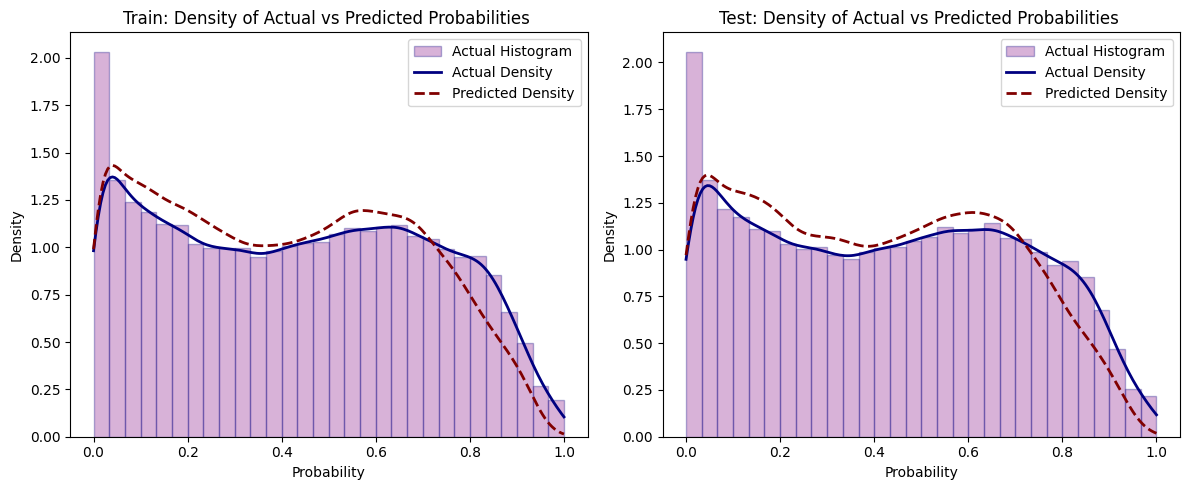

In [21]:
# KDEs for actual and predicted
kde_train_actual = gaussian_kde(y_train_prob)
kde_train_pred = gaussian_kde(y_train_hat)

kde_test_actual = gaussian_kde(y_test_prob)
kde_test_pred = gaussian_kde(y_test_hat)

# Grid for density curves
x_grid = np.linspace(0, 1, 200)

plt.figure(figsize=(12,5))

# Train set densities
plt.subplot(1,2,1)
plt.hist(y_train_prob, bins=30, color='purple', edgecolor='navy', alpha=0.3, density=True, label="Actual Histogram")
plt.plot(x_grid, kde_train_actual(x_grid), color='navy', linewidth=2, label="Actual Density")
plt.plot(x_grid, kde_train_pred(x_grid), color='maroon', linewidth=2, linestyle='--', label="Predicted Density")
plt.title("Train: Density of Actual vs Predicted Probabilities ")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()

# Test set densities
plt.subplot(1,2,2)
plt.hist(y_test_prob, bins=30, color='purple', edgecolor='navy', alpha=0.3, density=True, label="Actual Histogram")
plt.plot(x_grid, kde_test_actual(x_grid), color='navy', linewidth=2, label="Actual Density")
plt.plot(x_grid, kde_test_pred(x_grid), color='maroon', linewidth=2, linestyle='--', label="Predicted Density")
plt.title("Test: Density of Actual vs Predicted Probabilities ")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

## Feature Selection

In [22]:
y_col = "target"
X_cols = [c for c in df.columns if c != y_col]

X_selection = df_selection[X_cols].copy()
y_selection = df_selection[y_col].copy()

# Standardize
scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X_selection), columns=X_selection.columns)

# -------------------------
def compute_mi(X, y):
    mi = mutual_info_regression(X, y, random_state=0)
    return pd.Series(mi, index=X.columns).sort_values(ascending=False)

mi_scores = compute_mi(Xs, y_selection)

In [23]:
k = 15  # adjust as needed
selected_features = mi_scores.head(k).index.tolist()

Xsel = Xs[selected_features]

print(f"Selected {len(selected_features)} features: {selected_features}")

Selected 15 features: ['CONC_R', 'LOG_PETROR50_R', 'FRACDEV_R', 'MU50_R', 'PSFMAG_R', 'FIBERMAG_R', 'LOG_PETROMAGERR_MZ', 'LOG_PETROMAGERR_Z', 'PETROMAG_MI', 'PETROMAG_MZ', 'LOG_PETROR50_R_KPC', 'LOG_PETROR90_R', 'PETROMAG_U_corr', 'PETROMAG_MR', 'PETROMAG_MG']


### for experimenting

In [ ]:
groups = { 'R_band_mag': ['PSFMAG_R', 'FIBERMAG_R', 'DEVMAG_R', 'EXPMAG_R', 'CMODELMAG_R'], 
           'Petrosian_mag': ['PETROMAG_U_corr', 'PETROMAG_G_corr', 'PETROMAG_R_corr', 'PETROMAG_I_corr', 'PETROMAG_Z_corr'], 
           'Model_mag': ['PETROMAG_MU', 'PETROMAG_MG', 'PETROMAG_MR', 'PETROMAG_MI', 'PETROMAG_MZ'], 
           'Mag_errors': ['LOG_PETROMAGERR_U', 'LOG_PETROMAGERR_G', 'LOG_PETROMAGERR_R', 'LOG_PETROMAGERR_I', 'LOG_PETROMAGERR_Z', 'LOG_PETROMAGERR_MU', 'LOG_PETROMAGERR_MG', 'LOG_PETROMAGERR_MR', 'LOG_PETROMAGERR_MI', 'LOG_PETROMAGERR_MZ'], 
           'Size_shape': ['FRACDEV_R', 'MU50_R', 'CONC_R', 'LOG_PETROR50_R', 'LOG_PETROR90_R', 'LOG_PETROR50_R_KPC'], 
           'Redshift': ['REDSHIFT', 'REDSHIFTERR'], 
           'Other_errors': ['LOG_DEVMAGERR_R', 'LOG_EXPMAGERR_R', 'LOG_CMODELMAGERR_R'] }

def select_features_by_group(groups, Xs, y):
    """
    Select top feature per group based on mutual information with the target.
    
    Parameters:
    -----------
    groups : dict
        Dictionary where keys are group names and values are lists of feature names.
    Xs : pd.DataFrame
        Standardized feature dataframe.
    y : pd.Series
        Target variable.
    
    Returns:
    --------
    selected_features : list
        List of selected features (one per group) with highest MI in each group.
    mi_scores_group : pd.Series
        MI scores for selected features.
    """
    selected_features = []
    mi_scores_group = {}
    
    for group_name, features in groups.items():
        # keep only features present in Xs
        features_present = [f for f in features if f in Xs.columns]
        if not features_present:
            continue
        
        # compute MI
        mi = mutual_info_regression(Xs[features_present], y, random_state=0)
        mi_series = pd.Series(mi, index=features_present)
        
        # select feature with highest MI in this group
        top_feat = mi_series.idxmax()
        selected_features.append(top_feat)
        mi_scores_group[top_feat] = mi_series[top_feat]
    
    mi_scores_group = pd.Series(mi_scores_group).sort_values(ascending=False)
    return selected_features, mi_scores_group

selected_feats, mi_scores = select_features_by_group(groups, Xs, y)
print("Selected features per group:", selected_feats)
print("\nMutual information of selected features:\n", mi_scores)

Selected features per group: ['PSFMAG_R', 'PETROMAG_U_corr', 'PETROMAG_MZ', 'LOG_PETROMAGERR_MZ', 'CONC_R', 'REDSHIFT', 'LOG_DEVMAGERR_R']

Mutual information of selected features:
 CONC_R                0.154660
PSFMAG_R              0.116970
LOG_PETROMAGERR_MZ    0.095594
PETROMAG_MZ           0.094603
PETROMAG_U_corr       0.081675
REDSHIFT              0.060455
LOG_DEVMAGERR_R       0.049191
dtype: float64


## GAM with Selected Features

In [24]:
# Separate predictors and target from df_inference
# 1. Get the list of feature names BEFORE converting to .values
feature_cols = selected_features
X_data = df_inference[feature_cols] # Keep as DataFrame for now
y_inf = df_inference["target"].values
y_inf_logit = logit(np.clip(y_inf, 1e-6, 1-1e-6))

# 2. Standardize features
scaler = StandardScaler()
# Transform the values, which returns a NumPy array
X_scaled_array = scaler.fit_transform(X_data.values) 

# 3. Create X_scaled_inf DataFrame, restoring column names (THE CRITICAL FIX)
X_scaled_inf = pd.DataFrame(
    X_scaled_array,
    columns=feature_cols # <-- FIX: Use the original list of names here
)

# 4. Train/test split
# X_train_inf and X_test_inf will now retain the correct string column names!
X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(
    X_scaled_inf, y_inf_logit, test_size=0.7
)

In [25]:
# Build spline terms for all features
gam_selected = build_gam(len(selected_features), 25)

# Fit GAM
gam_selected_fit = gam_selected.fit(X_train_inf, y_train_inf)

# Model summary
gam_selected_fit.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    234.1731
Link Function:                     IdentityLink Log Likelihood:                                -99688.1593
Number of Samples:                        41250 AIC:                                           199846.6647
                                                AICc:                                          199849.3731
                                                GCV:                                                3.9824
                                                Scale:                                              3.9417
                                                Pseudo R-Squared:                                    0.412
Feature Function                  Lam

C:\Users\sikha\AppData\Local\Temp\ipykernel_20692\3164928582.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_selected_fit.summary()


In [26]:
r2_train, r2_test, corr_train, corr_test, y_train_prob, y_test_prob, y_train_hat, y_test_hat = gam_inference(gam_selected_fit, X_train_inf, X_test_inf, y_train_inf, y_test_inf)

print("Train R^2:", round(r2_train, 2))
print("Test R^2:", round(r2_test, 2))
print("\nTrain corr(y, y_hat):", round(corr_train, 2))
print("Test corr(y, y_hat):", round(corr_test, 2))

Train R^2: 0.48
Test R^2: 0.48

Train corr(y, y_hat): 0.73
Test corr(y, y_hat): 0.73


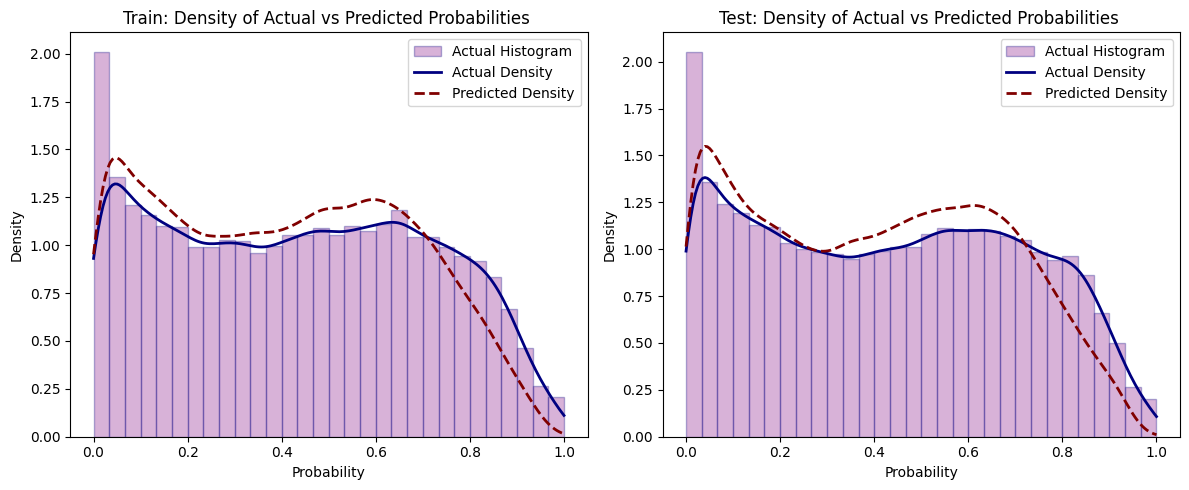

In [27]:
# KDEs for actual and predicted
kde_train_actual = gaussian_kde(y_train_prob)
kde_train_pred = gaussian_kde(y_train_hat)

kde_test_actual = gaussian_kde(y_test_prob)
kde_test_pred = gaussian_kde(y_test_hat)

# Grid for density curves
x_grid = np.linspace(0, 1, 200)

plt.figure(figsize=(12,5))

# Train set densities
plt.subplot(1,2,1)
plt.hist(y_train_prob, bins=30, color='purple', edgecolor='navy', alpha=0.3, density=True, label="Actual Histogram")
plt.plot(x_grid, kde_train_actual(x_grid), color='navy', linewidth=2, label="Actual Density")
plt.plot(x_grid, kde_train_pred(x_grid), color='maroon', linewidth=2, linestyle='--', label="Predicted Density")
plt.title("Train: Density of Actual vs Predicted Probabilities ")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()

# Test set densities
plt.subplot(1,2,2)
plt.hist(y_test_prob, bins=30, color='purple', edgecolor='navy', alpha=0.3, density=True, label="Actual Histogram")
plt.plot(x_grid, kde_test_actual(x_grid), color='navy', linewidth=2, label="Actual Density")
plt.plot(x_grid, kde_test_pred(x_grid), color='maroon', linewidth=2, linestyle='--', label="Predicted Density")
plt.title("Test: Density of Actual vs Predicted Probabilities ")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# Initialize results DataFrame with float dtype
results_df = pd.DataFrame({
    "splines": range(5, 51, 3),
    "R^2_train": np.nan,
    "R^2_test": np.nan
}).set_index("splines")

for i in results_df.index:
    gam_selected = build_gam(len(selected_features), i)
    gam_selected_fit = gam_selected.fit(X_train_inf, y_train_inf)

    r2_train, r2_test, corr_train, corr_test, y_train_prob, y_test_prob, y_train_hat, y_test_hat = gam_inference(gam_selected_fit, X_train_inf, X_test_inf, y_train_inf, y_test_inf)

    results_df.loc[i, "R^2_train"] = r2_train
    results_df.loc[i, "R^2_test"] = r2_test

## Exploring Number of Splines

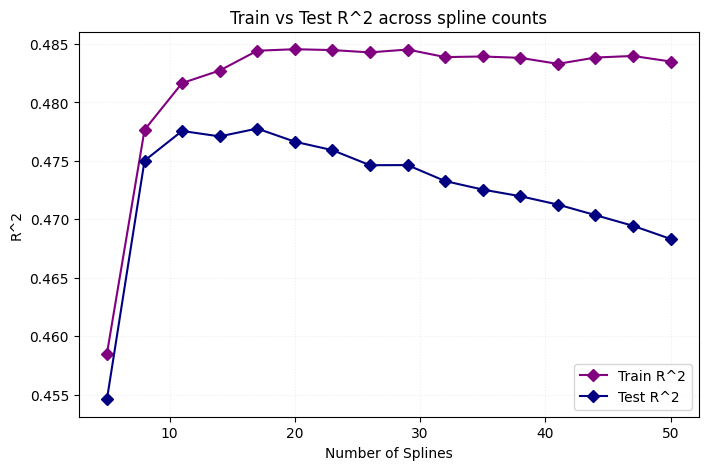

In [29]:
plt.figure(figsize=(8,5))

# Plot train R^2 in pink
plt.plot(results_df.index, results_df["R^2_train"], color="purple", marker="D", label="Train R^2")

# Plot test R^2 in blue
plt.plot(results_df.index, results_df["R^2_test"], color="navy", marker="D", label="Test R^2")

# Labels and title
plt.xlabel("Number of Splines")
plt.ylabel("R^2")
plt.title("Train vs Test R^2 across spline counts")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.2)

plt.show()

## Exploring Number of Splines and Lambda

In [32]:
# Define ranges
splines_range = range(5, 51, 5)
lambda_range = [0, 0.01, 0.1, 1, 10, 100]

# Pre-create MultiIndex for all (spline_k, lambda) combinations
index = pd.MultiIndex.from_product([splines_range, lambda_range],
                                   names=["spline_k", "lambda"])
results_df = pd.DataFrame(index=index, columns=["R^2_train", "R^2_test"])

# Loop over grid
for spline_k in splines_range:
    for lam in lambda_range:
        # Build and fit GAM
        gam_selected = build_gam(len(selected_features), spline_k=spline_k, lamb=lam)
        gam_selected_fit = gam_selected.fit(X_train_inf, y_train_inf)

        # Run inference
        (r2_train, r2_test, corr_train, corr_test, y_train_prob, y_test_prob, y_train_hat, y_test_hat) = gam_inference(gam_selected_fit, X_train_inf, X_test_inf, y_train_inf, y_test_inf)

        # Store results
        results_df.loc[(spline_k, lam), "R^2_train"] = r2_train
        results_df.loc[(spline_k, lam), "R^2_test"] = r2_test

# Inspect results
print(results_df)

                R^2_train  R^2_test
spline_k lambda                    
5        0.00    0.472511  0.470648
         0.01     0.47162  0.469603
         0.10    0.469267  0.466297
         1.00    0.458532  0.454625
         10.00   0.424918   0.42053
         100.00  0.353294  0.351391
10       0.00    0.482257  0.476744
         0.01    0.481548  0.477688
         0.10    0.480804  0.477446
         1.00    0.479196  0.476503
         10.00   0.477073  0.474306
         100.00  0.464342  0.460732
15       0.00    0.484385  0.473759
         0.01    0.484051  0.475506
         0.10    0.484088  0.476392
         1.00    0.483786  0.477346
         10.00   0.482265  0.477365
         100.00   0.47867   0.47486
20       0.00    0.484553  0.472464
         0.01    0.484087  0.474356
         0.10    0.484254  0.475329
         1.00    0.484546   0.47664
         10.00    0.48374  0.477523
         100.00  0.481807  0.477284
25       0.00    0.484131  0.470319
         0.01    0.483611  0

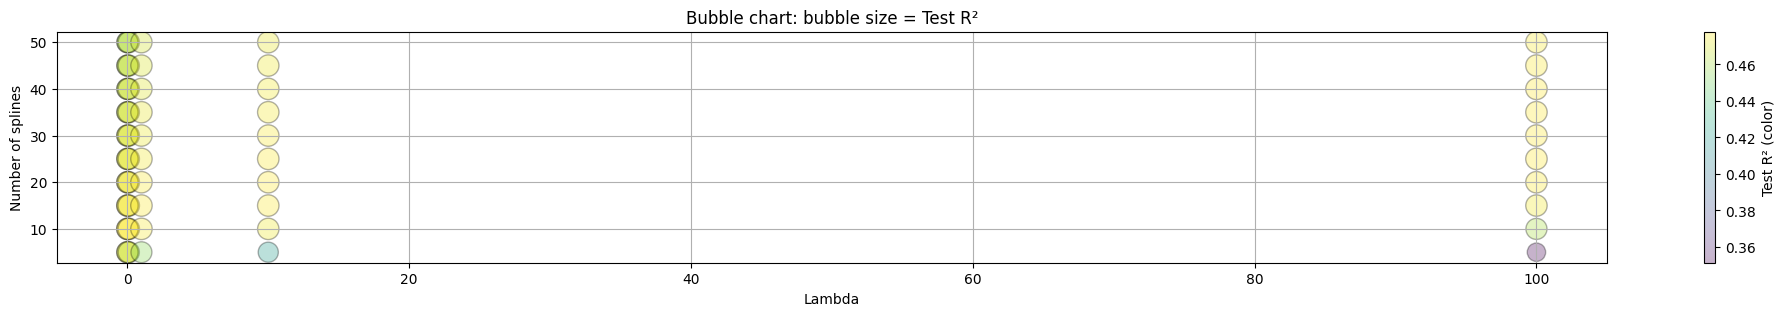

In [41]:
# results_df1 = results_df.drop(index=0.001, level="lambda")

# Reset index to get splines and lambda as columns
plot_df = results_df.reset_index().dropna(subset=["R^2_test"])

# Prepare data
X_plot = plot_df["lambda"].values
Y_plot = plot_df["spline_k"].values
R2_test = plot_df["R^2_test"].astype(float).values

# Bubble size proportional to R² (scale factor adjustable)
S_plot = R2_test * 500

plt.figure(figsize=(25,3))
scatter = plt.scatter(X_plot, Y_plot, s=S_plot, alpha=0.3, c=R2_test, cmap="viridis",edgecolors="k")

plt.xlabel("Lambda")
plt.ylabel("Number of splines")
plt.title("Bubble chart: bubble size = Test R²")
plt.grid(True)

# Add colorbar to indicate R² values
cbar = plt.colorbar(scatter)
cbar.set_label("Test R² (color)")

plt.show()
# print(results_df.xs(14, level="spline_k"))

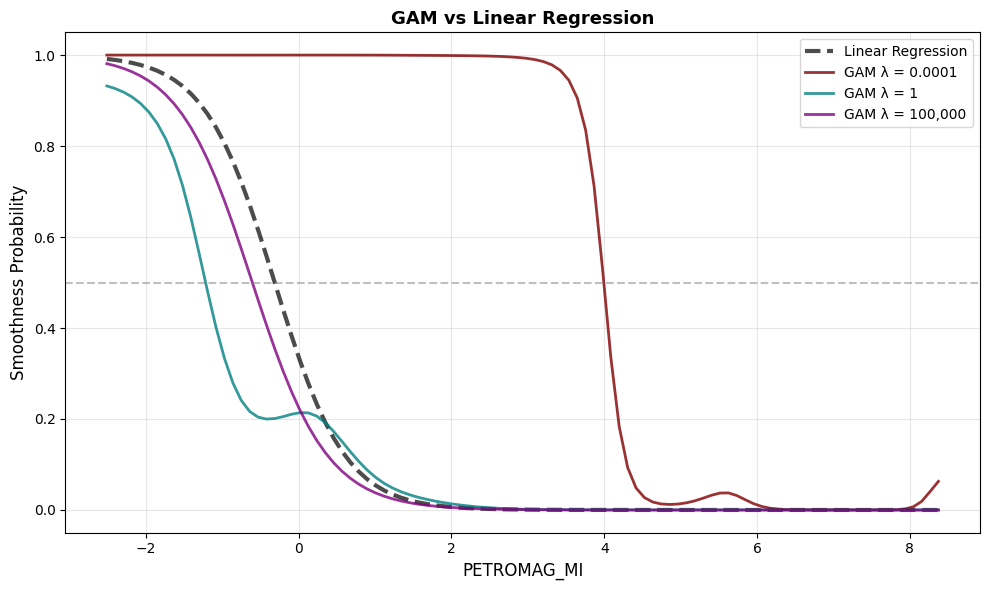

In [48]:
feature_name = 'PETROMAG_MI'
feature_index = list(X_train_inf.columns).index(feature_name)

lambda_test = [0.0001, 1, 100000]
colors = ['maroon', 'teal', 'purple']
labels = ['GAM λ = 0.0001','GAM λ = 1', 'GAM λ = 100,000']

fig, ax = plt.subplots(figsize=(10, 6))

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train_inf.values, y_train_inf)

# Create grid using first GAM
gam_temp = build_gam(len(selected_features), spline_k=15, lamb=1.0)
gam_temp.fit(X_train_inf.values, y_train_inf)
XX_grid = gam_temp.generate_X_grid(term=feature_index)

# Linear regression FULL prediction (includes intercept + all features)
y_linear_logit = lr.predict(XX_grid)
y_linear_prob = expit(y_linear_logit)

x_vals_lr = XX_grid[:, feature_index].flatten()
if y_linear_prob.ndim > 1:
    y_linear_prob = y_linear_prob.flatten()
min_len_lr = min(len(x_vals_lr), len(y_linear_prob))

ax.plot(x_vals_lr[:min_len_lr], y_linear_prob[:min_len_lr], 'k--', linewidth=3, label='Linear Regression', alpha=0.7)

for lam, color, label in zip(lambda_test, colors, labels):
    gam = build_gam(len(selected_features), spline_k=15, lamb=lam)
    gam.fit(X_train_inf.values, y_train_inf)
    
    XX = gam.generate_X_grid(term=feature_index)
    
    y_gam_logit = gam.predict(XX)
    y_gam_prob = expit(y_gam_logit)
    
    x_vals = XX[:, feature_index].flatten()
    if y_gam_prob.ndim > 1:
        y_gam_prob = y_gam_prob.flatten()
    
    min_len = min(len(x_vals), len(y_gam_prob))
    
    ax.plot(x_vals[:min_len], y_gam_prob[:min_len], color=color, linewidth=2, label=label, alpha=0.8)

ax.set_xlabel('PETROMAG_MI', fontsize=12)
ax.set_ylabel('Smoothness Probability', fontsize=12)
ax.set_title('GAM vs Linear Regression', fontsize=13, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## BootStrapping

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from scipy.special import expit

def uniform_wild_bootstrap_bands(gam, X_train, y_train,
                                feature_names=None,
                                n_bootstrap=200, seed=42, verbose=True):
    """
    Compute uniform (simultaneous) 95% confidence bands for each smooth term
    using a wild bootstrap (Rademacher ±1 multipliers), non-studentized.

    Returns dict keyed by feature name:
        ci_uniform[feature] = {
            grid, orig, lower, upper, median, curves
        }
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]

    # If no names provided → use numeric index 0,1,2,...
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

    # Identify non-intercept terms
    term_idxs = [i for i, t in enumerate(gam.terms) if not t.isintercept]

    # Original fitted values + residuals
    fitted_orig = gam.predict(X_train)
    residuals = y_train - fitted_orig

    if verbose:
        print(f"\nBootstrapping {n_bootstrap} draws for {len(term_idxs)} GAM terms…")

    # Prepare storage
    ci_uniform = {}
    grids = {}
    orig_pdep = {}

    # Original partial dependencies
    for term in term_idxs:
        XX = gam.generate_X_grid(term=term)
        pdep = gam.partial_dependence(term=term, X=XX)
        grids[term] = XX[:, term]
        orig_pdep[term] = expit(pdep.flatten())
        ci_uniform[feature_names[term]] = {"bootstrap_curves": []}

    # Wild bootstrap
    for b in range(n_bootstrap):
        if verbose and (b % max(1, n_bootstrap//10) == 0):
            print(f"  Bootstrap {b+1}/{n_bootstrap}")
        # Rademacher multipliers
        v = rng.choice([-1, 1], size=n_samples)
        # Generate bootstrap response
        y_boot = fitted_orig + residuals * v
        # Fit bootstrap GAM
        gam_boot = LinearGAM(gam.terms).fit(X_train, y_boot)

        # Evaluate bootstrap PDP on same grid as original
        for term in term_idxs:
            XX = gam.generate_X_grid(term=term)
            pdep_boot = gam_boot.partial_dependence(term=term, X=XX)
            ci_uniform[feature_names[term]]["bootstrap_curves"].append(expit(pdep_boot.flatten()))

    # Compute uniform bands (non-studentized)
    for term in term_idxs:
        name = feature_names[term]
        curves = np.array(ci_uniform[name]["bootstrap_curves"])   # (B, n_grid)
        lower = np.min(curves, axis=0)
        upper = np.max(curves, axis=0)
        median = np.median(curves, axis=0)

        ci_uniform[name].update({
            "grid": grids[term],
            "orig": orig_pdep[term],
            "lower": lower,
            "upper": upper,
            "median": median,
            "curves": curves
        })

    if verbose:
        print("\n✔ Uniform CI computation complete.")
    return ci_uniform

ci_uniform = uniform_wild_bootstrap_bands(
    gam,
    X_train_inf.values if hasattr(X_train_inf, 'values') else X_train_inf,
    y_train_inf,
    feature_names=selected_features,
    n_bootstrap=100,
    seed=42
)


Bootstrapping 100 draws for 15 GAM terms…
  Bootstrap 1/100
  Bootstrap 11/100
  Bootstrap 21/100
  Bootstrap 31/100
  Bootstrap 41/100
  Bootstrap 51/100
  Bootstrap 61/100
  Bootstrap 71/100
  Bootstrap 81/100
  Bootstrap 91/100

✔ Uniform CI computation complete.


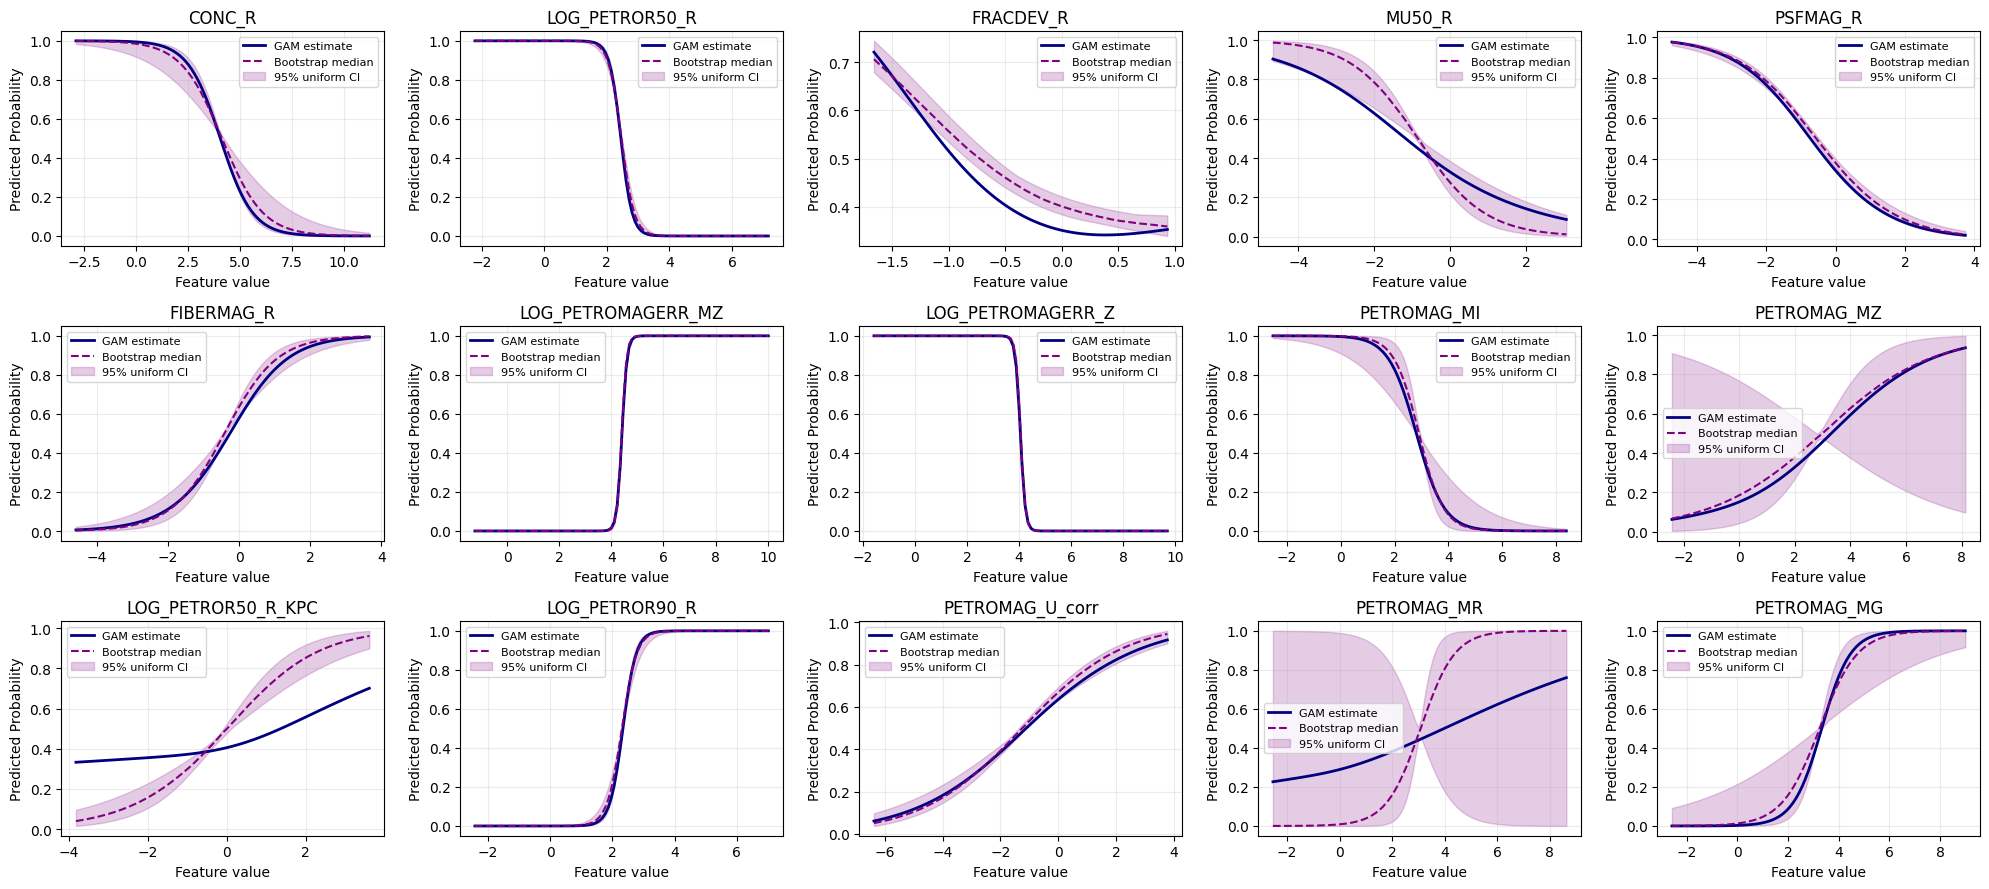

In [50]:
def plot_uniform_ci(ci_uniform, n_cols=5):
    """
    Plot each feature with original GAM, bootstrap median, and uniform CI.
    """
    n_features = len(ci_uniform)
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axes = axes.flatten() if n_features > 1 else [axes]

    for i, (feature, d) in enumerate(ci_uniform.items()):
        ax = axes[i]
        # Original GAM curve (navy)
        ax.plot(d["grid"], d["orig"], color="navy", lw=2, label="GAM estimate")
        # Bootstrap median (dashed purple)
        ax.plot(d["grid"], d["median"], linestyle="--", color="purple", lw=1.5, label="Bootstrap median")
        # Uniform band (soft purple)
        ax.fill_between(d["grid"], d["lower"], d["upper"], color="purple", alpha=0.2, label="95% uniform CI")
        ax.set_title(feature )
        ax.set_xlabel("Feature value")
        ax.set_ylabel("Predicted Probability")
        ax.grid(alpha=0.25)
        ax.legend(fontsize=8)

    # Hide any empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
plot_uniform_ci(ci_uniform, n_cols=5)


In [273]:
import pandas as pd
import numpy as np

# --- Configuration (Assumes gam_selected_fit and selected_features are defined) ---

# 1. Get the statistics dictionary
stats = gam_selected_fit.statistics_

# 2. Get the P-values for the smooth terms
# The P-values for smooth terms are stored in the 'p_values' key.
# We skip the first P-value, as it belongs to the intercept (which is usually not of interest here).
p_values = stats['p_values'][1:] 

# 3. Get the feature names
# We use the names for the features that correspond to the smooth terms (skipping the intercept)
term_names = selected_features 

# 4. Check that the lengths match (sanity check)
if len(p_values) != len(term_names):
    print("Warning: Length mismatch between P-values and feature names.")
    print(f"P-value count: {len(p_values)}, Feature count: {len(term_names)}")
    # If there's a mismatch, we can't accurately map the results.
    
# --- Print the Formatted Table ---
print("## 📈 GAM Feature Significance (P-Values) ##")
print("-" * 45)
print(f"{'Feature Name':<30} | {'P-Value':<10}")
print("-" * 45)

for name, p_value in zip(term_names, p_values):
    # Highlight significant P-values (p < 0.05)
    significance_flag = "(*)" if p_value < 0.05 else ""
    
    print(f"{name:<30} | {p_value:<10.5f} {significance_flag}")

print("-" * 45)
print("\n(*) Indicates statistical significance (P < 0.05)")

## 📈 GAM Feature Significance (P-Values) ##
---------------------------------------------
Feature Name                   | P-Value   
---------------------------------------------
CONC_R                         | 0.00000    (*)
LOG_PETROR50_R                 | 0.00000    (*)
FRACDEV_R                      | 0.00000    (*)
MU50_R                         | 0.00000    (*)
PSFMAG_R                       | 0.00000    (*)
FIBERMAG_R                     | 0.00000    (*)
LOG_PETROMAGERR_MZ             | 0.00000    (*)
LOG_PETROMAGERR_Z              | 0.00000    (*)
PETROMAG_MI                    | 0.00000    (*)
PETROMAG_MZ                    | 0.00000    (*)
LOG_PETROR50_R_KPC             | 0.21889    
LOG_PETROR90_R                 | 0.00000    (*)
PETROMAG_U_corr                | 0.00000    (*)
PETROMAG_MR                    | 0.00000    (*)
PETROMAG_MG                    | 0.00000    (*)
---------------------------------------------

(*) Indicates statistical significance (P < 0.05)
